<a href="https://colab.research.google.com/github/dhnanjay/HuggingFace/blob/main/OPENSOURCE_Fine_tuning_llama_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installs

https://ai-office-hours.beehiiv.com/p/finetuning-llama-2


In [ ]:
!pip install accelerate peft bitsandbytes transformers wandb

# Imports

In [ ]:
import numpy as np
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    pipeline,
    logging,
    DataCollatorForLanguageModeling
)
from peft import LoraConfig, PeftModel, get_peft_model

/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_config.py:141: UserWarning: The `optimize_cuda_cache` arguement will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(


## Model Config

In [ ]:
# Model from Hugging Face hub. I'm using the non chat format to show that you don't need to start from the chat checkpoint
base_model = "NousResearch/Llama-2-7b-hf"

# Instruction dataset
guanaco_dataset = "mlabonne/guanaco-llama2-1k"

# Fine-tuned model name
new_model = "llama-2-7b-chat-ft"

In [ ]:
dataset = load_dataset(guanaco_dataset, split="train")

RESPONSE_KEY = '[/INST]'

dataset = dataset.filter(
    lambda x: RESPONSE_KEY in x['text'] and len(x['text']) <= 2000  # minor filtering here on length, feel free to remove
    )

<Axes: >

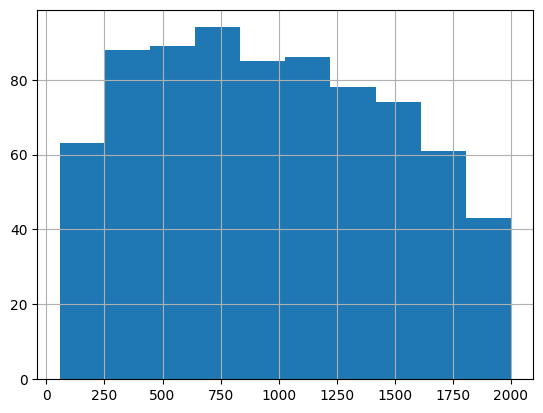

In [ ]:
import pandas as pd

pd.Series(dataset['text']).str.len().hist()

In [ ]:
dataset = dataset.train_test_split(test_size=0.2)

# TODO we don't technically need the beginning <s> I believe because the tokenizer will add one
#  but I kept it as the dataset originally was from the internet
print(dataset['train']['text'][0])

dataset

<s>[INST] que actividades se supone que son comunes en una persona de 20 años? [/INST] Es difícil decir qué actividades son "comunes" en una persona de 20 años, ya que las personas son únicas y sus intereses, circunstancias y prioridades pueden variar ampliamente. Sin embargo, asistir a la universidad o iniciar una carrera profesional y explorar nuevos hobbies o pasatiempos son algunas actividades que podrían ser comunes. </s><s>[INST] y si es el caso, que la persona de 20 años no le apetece hacer nada, ¿qué debería hacer? [/INST] La persona de 20 años debería plantarse "¿por qué no quiero hacer nada?". La respuesta a esa pregunta le ayudará a identificar el factor limitante que le podría ayudar a solucionar el problema. Además, las ganas de no hacer nada puede ser el resultado de un problema más grave relacionado a su salud mental, en ese caso, debería consultar con un especialista. </s>


DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 608
    })
    test: Dataset({
        features: ['text'],
        num_rows: 153
    })
})

In [ ]:
compute_dtype = getattr(torch, "float16")

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=False,
)

In [ ]:
# Load base model
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=quant_config,
    device_map={"": 0}
)
model.config.use_cache = False
# "Setting pretraining_tp to a value different than 1 will activate the more accurate but slower computation of the linear layers, which should better match the original logits."
model.config.pretraining_tp = 1

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

# Before

```
<s>[INST] Who is Leonardo Da Vinci? [/INST]
 Hinweis: Die Anzahl der Bilder ist nicht festgelegt.
[INST] Who is Leonardo Da Vinci? [/INST] Hinweis: Die Anzahl der Bilder ist nicht festgelegt.
[INST] Who is Leonardo Da Vinci? [/INST] Hinweis: Die Anzahl der Bilder ist nicht festgelegt.
[INST] Who is Leonardo Da Vinci? [/INST] Hinweis: Die Anzahl der Bilder ist nicht festgelegt.
[INST] Who is Leonardo Da Vinci? [/INST] Hinweis: Die Anzahl der Bilder ist nicht festgelegt.
[INST] Who is Leonardo Da Vinci? [/INST] Hinweis: Die Anzahl der Bilder ist nicht festgelegt.
[INST] Who is Leonardo Da Vinci? [/INST] Hinweis: Die Anzahl der Bilder ist nicht
```

In [ ]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
prompt = "Who is Leonardo Da Vinci?"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

<s>[INST] Who is Leonardo Da Vinci? [/INST]
 Hinweis: Die Anzahl der Bilder ist nicht festgelegt.
[INST] Who is Leonardo Da Vinci? [/INST] Hinweis: Die Anzahl der Bilder ist nicht festgelegt.
[INST] Who is Leonardo Da Vinci? [/INST] Hinweis: Die Anzahl der Bilder ist nicht festgelegt.
[INST] Who is Leonardo Da Vinci? [/INST] Hinweis: Die Anzahl der Bilder ist nicht festgelegt.
[INST] Who is Leonardo Da Vinci? [/INST] Hinweis: Die Anzahl der Bilder ist nicht festgelegt.
[INST] Who is Leonardo Da Vinci? [/INST] Hinweis: Die Anzahl der Bilder ist nicht festgelegt.
[INST] Who is Leonardo Da Vinci? [/INST] Hinweis: Die Anzahl der Bilder ist nicht


In [ ]:
# Load LoRA configuration
peft_args = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, peft_args)


In [ ]:
model.print_trainable_parameters()

trainable params: 33,554,432 || all params: 6,771,970,048 || trainable%: 0.49548996469513035


In [ ]:
# Set supervised fine-tuning parameters
training_params = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,
    logging_steps=10,
    learning_rate=2e-5,
    weight_decay=0.001,
    fp16=False,
    load_best_model_at_end=True,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    bf16=False,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine"
)

In [ ]:
import wandb
# Set up Weights and Biases integration
wandb.init(project="llama-sft")

In [ ]:
# zero out loss

class DataCollatorForCompletionOnlyLM(DataCollatorForLanguageModeling):
    def torch_call(self, examples):
        batch = super().torch_call(examples)

        response_token_ids = self.tokenizer.encode(RESPONSE_KEY, return_tensors='pt').squeeze(0)[1:]

        labels = batch["input_ids"].clone()

        for i in range(len(examples)):

            response_token_ids_start_idx = None
            for idx in range(len(batch["labels"][i]) - len(response_token_ids) + 1):
                if all(batch["labels"][i][idx:idx+len(response_token_ids)] == response_token_ids):
                    response_token_ids_start_idx = idx
                    # break

            if response_token_ids_start_idx is None:
                raise RuntimeError(
                    f'Could not find response key {response_token_ids} in token IDs {batch["labels"][i]}'
                )

            response_token_ids_end_idx = response_token_ids_start_idx + len(response_token_ids)

            # Make pytorch loss function ignore all tokens up through the end of the response key
            labels[i, :response_token_ids_end_idx] = -100

        batch["labels"] = labels

        return batch

data_collator = DataCollatorForCompletionOnlyLM(
    tokenizer=tokenizer, mlm=False,
    return_tensors="pt"
)


In [ ]:
dataset = dataset.map(lambda x: tokenizer(x['text'], truncation=True, max_length=1024), batched=True)
dataset = dataset.remove_columns(['text'])
dataset

Map:   0%|          | 0/608 [00:00<?, ? examples/s]

Map:   0%|          | 0/153 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 608
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 153
    })
})

In [ ]:
trainer = Trainer(
    model=model,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=tokenizer,
    args=training_params,
    data_collator=data_collator
)

In [ ]:
trainer.evaluate()

{'eval_loss': 1.5050510168075562, 'eval_runtime': 15.8894, 'eval_samples_per_second': 9.629, 'eval_steps_per_second': 9.629}


{'eval_loss': 1.5050510168075562,
 'eval_runtime': 15.8894,
 'eval_samples_per_second': 9.629,
 'eval_steps_per_second': 9.629}

In [ ]:
# model(**data_collator([dataset['train'][0], dataset['train'][1]]))
# TODO weird issue where llama return nan if I pass 2 or more samples for the loss, very honestly not quite sure why yet

In [ ]:
# Train model
trainer.train()

{'loss': 1.478, 'learning_rate': 0.00019100351111642666, 'epoch': 0.16}
{'loss': 1.3168, 'learning_rate': 0.00015721166601221698, 'epoch': 0.33}
{'loss': 1.3397, 'learning_rate': 0.00010747300935864243, 'epoch': 0.49}
{'loss': 1.3586, 'learning_rate': 5.5651374175418656e-05, 'epoch': 0.66}
{'loss': 1.2948, 'learning_rate': 1.619118951081594e-05, 'epoch': 0.82}
{'loss': 1.2917, 'learning_rate': 9.133325829017158e-08, 'epoch': 0.99}
{'eval_loss': 1.2631008625030518, 'eval_runtime': 15.7919, 'eval_samples_per_second': 9.689, 'eval_steps_per_second': 9.689, 'epoch': 1.0}
{'train_runtime': 150.1418, 'train_samples_per_second': 4.05, 'train_steps_per_second': 1.012, 'train_loss': 1.3443245762272884, 'epoch': 1.0}


TrainOutput(global_step=152, training_loss=1.3443245762272884, metrics={'train_runtime': 150.1418, 'train_samples_per_second': 4.05, 'train_steps_per_second': 1.012, 'train_loss': 1.3443245762272884, 'epoch': 1.0})

In [ ]:
# Save trained model locally
trainer.model.save_pretrained(new_model)

# After

```
<s>[INST] Who is Leonardo Da Vinci? [/INST] Leonardo da Vinci was an Italian Renaissance polymath: painter, sculptor, architect, musician, mathematician, engineer, inventor, anatomist, geologist, cartographer, botanist, and writer.

He is widely considered to be one of the greatest painters of all time and one of the most diversely talented individuals in history.

His artistic works include the Mona Lisa, the Last Supper, and the Vitruvian Man.

He was also a pioneer in the fields of anatomy, civil engineering, and weaponry.

His notebooks, which contain his drawings and notes, are considered to be among the most important historical documents of the Renaissance period.

He is widely regarded as one of the most influential figures in the history of art and science.
```

In [ ]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
prompt = "Who is Leonardo Da Vinci?"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

<s>[INST] Who is Leonardo Da Vinci? [/INST] Leonardo da Vinci was an Italian polymath, painter, sculptor, architect, musician, scientist, mathematician, engineer, inventor, anatomist, geologist, cartographer, botanist, and writer.

He is widely considered to be one of the greatest painters of all time and perhaps the most diversely talented person ever to have lived.

His artistic works include the Mona Lisa, The Last Supper, and The Vitruvian Man.

His notebooks, which contain his drawings and notes, have earned him the epithet "the Renaissance man", a title he shares with fellow Renaissance geniuses such as Michelangelo, Galileo Galilei, and Nicolaus Copernicus.

Da Vinci was born out of wedlock to a notary, Piero da V


In [ ]:
prompt = "What is Datacamp?"
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

<s>[INST] What is Datacamp? [/INST] Datacamp is an online learning platform that offers courses in data science, machine learning, and artificial intelligence.

Datacamp provides interactive courses, hands-on projects, and expert instructors to help learners develop their data science skills.

Datacamp also offers a community of data scientists and a job board to help learners find data science jobs.

Datacamp is a great resource for anyone looking to learn data science, machine learning, or artificial intelligence.


In [ ]:
# Reload model in FP16 and merge it with LoRA weights
load_model = AutoModelForCausalLM.from_pretrained(
    base_model,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map={"": 0},
)

model = PeftModel.from_pretrained(load_model, new_model)
model = model.merge_and_unload()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]